# A train conversation on crowding distance


As a result from our train conversation I prepared the following IPython notebook that compares different alternatives to crowdwing distance as a "secondary" criterion in nondominated sorting.

In case you want to run this notebook on your own you need IPython and the DEAP library (https://www.github.com/DEAP/deap).

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import time, array, random, copy, math

import numpy as np

from deap import algorithms, base, benchmarks, tools, creator

from itertools import chain
from operator import attrgetter, itemgetter

In [3]:
from pynsgaiii import *

For the first experiments we use DTLZ2, which is a reasonably simple problem, and 5 objectives.

In [4]:
creator.create("FitnessMin2", base.Fitness, weights=(-1.0,) * 2)
creator.create("FitnessMin3", base.Fitness, weights=(-1.0,) * 3)
creator.create("FitnessMin5", base.Fitness, weights=(-1.0,) * 5)
creator.create("Individual2", array.array, typecode='d', 
               fitness=creator.FitnessMin2)
creator.create("Individual3", array.array, typecode='d', 
               fitness=creator.FitnessMin3)
creator.create("Individual5", array.array, typecode='d', 
               fitness=creator.FitnessMin5)

The `toolbox` contains the configuration of the algorithm:
* how to create an individual,
* how to create a population,
* the evolutionary operators,
* etc.

The `stats` object describes the statistics we want to collect. For flexibility, we will store whole populations for every iteration.

Using DEAP is very simple to code a flexible NSGA-II whose internal functions can be modified via the `toolbox`.

In [5]:
problems = {'DTLZ2': benchmarks.dtlz2, 'DTLZ3': benchmarks.dtlz3, 'DTLZ4': benchmarks.dtlz4}

In [6]:
number_of_variables = 30

In [7]:
BOUND_LOW, BOUND_UP = 0, 1

In [8]:
def calculate_pop_size(num_of_objs):
    return 10**(num_of_objs-1)

In [9]:
def create_problem_instance(problem_func, num_objs):
    return lambda ind: problem_func(ind, num_objs)

In [10]:
def prepare_toolbox(problem_instance, num_objs, selection_func):
    toolbox = base.Toolbox()
    
    toolbox.register('evaluate', problem_instance)
    toolbox.register('select', selection_func)
    
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, number_of_variables)
    
    if num_objs == 2:
        toolbox.register("individual", tools.initIterate, creator.Individual2, toolbox.attr_float)
    elif num_objs == 3:
        toolbox.register("individual", tools.initIterate, creator.Individual3, toolbox.attr_float)
    else:
        toolbox.register("individual", tools.initIterate, creator.Individual5, toolbox.attr_float)
        
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, 
                 low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, 
                 low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/number_of_variables)

    toolbox.pop_size = calculate_pop_size(num_objs)    # population size
    toolbox.max_gen = 200    # max number of iteration
    toolbox.mut_prob = 1/number_of_variables
    toolbox.cross_prob = 0.3
    
    return toolbox

In [11]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [12]:
stats = tools.Statistics()
stats.register("pop", copy.deepcopy)

In [13]:
toolbox = prepare_toolbox(lambda ind: benchmarks.dtlz2(ind, 3), 3, sel_nsga_iii)

In [14]:
pop = toolbox.population(n=20)

In [15]:
for ind in pop:
    ind.fitness.values = toolbox.evaluate(ind)

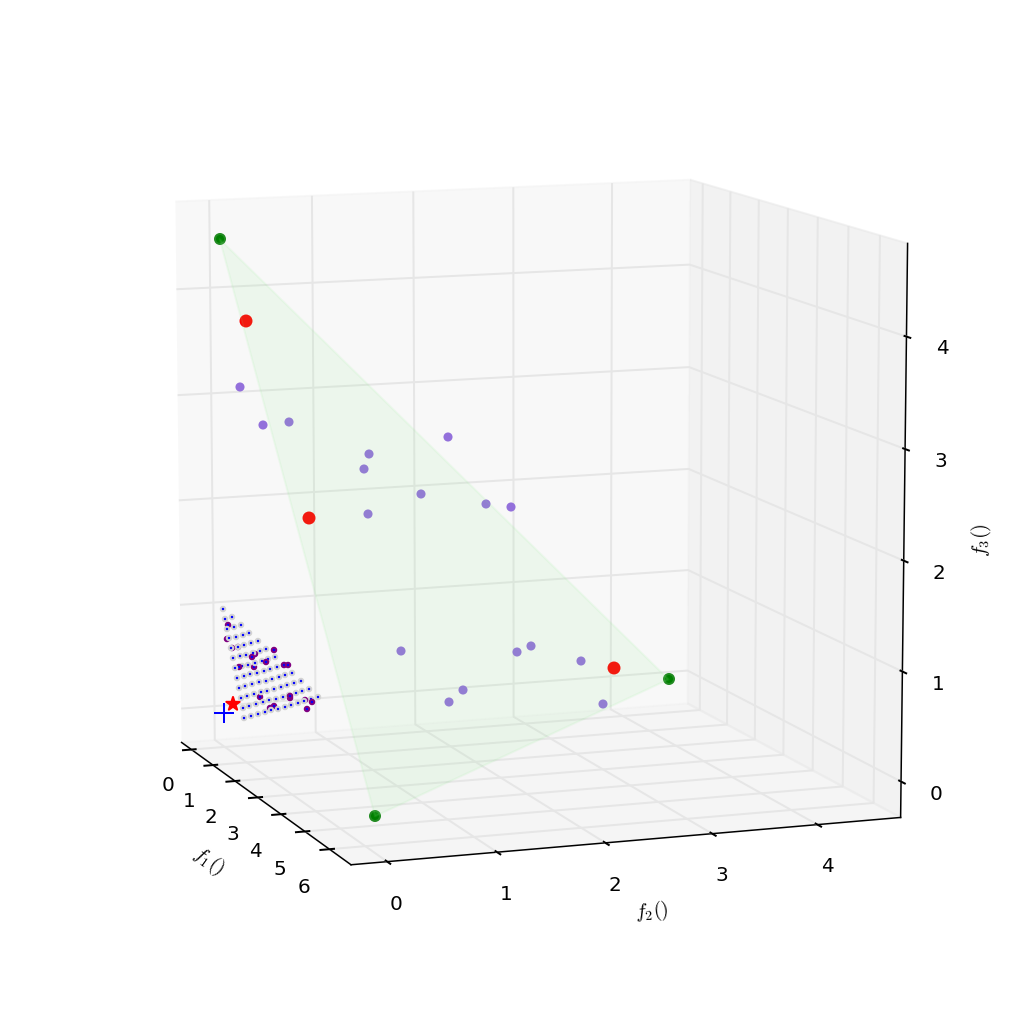

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as a3
from matplotlib.path import Path
import matplotlib.patches as patches

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
ax.scatter(0,0,0, c='k', marker='+', s=100)

# the population
for ind in pop:
    ax.scatter(ind.fitness.values[0],
               ind.fitness.values[1], 
               ind.fitness.values[2], 
               color='mediumpurple', c='mediumpurple',
               s=50, marker='.')

# ideal point -- a red star
ideal_point = find_ideal_point(pop)
ax.scatter(ideal_point[0], ideal_point[1], ideal_point[2],
           s=50, marker='*', color='red', c='red')

# extreme points marked with a blue x
extremes = find_extreme_points(pop)
for i,ex in enumerate(extremes):
    ax.scatter(ex.fitness.values[0],
               ex.fitness.values[1], 
               ex.fitness.values[2], s=30, c='r', marker='o', color='r')

# intercepts 
intercepts = construct_hyperplane(pop, extremes)
verts = [(intercepts[0], 0, 0), (0, intercepts[1], 0), (0, 0, intercepts[2])]

for vert in verts:
    ax.scatter(vert[0], vert[1], vert[2], c='green', color='forestgreen', s=100, marker='.')
    
tri = a3.art3d.Poly3DCollection([verts])
tri.set_color('lightgreen')
tri.set_alpha(0.11)
tri.set_edgecolor('lightgreen')
ax.add_collection3d(tri)

# normalized objectives
normalize_objectives(pop, intercepts, ideal_point)

for ind in pop:
    ax.scatter(ind.fitness.normalized_values[0], 
               ind.fitness.normalized_values[1], 
               ind.fitness.normalized_values[2], color='purple', marker='.')

# reference points
rps = generate_reference_points(3)
for rp in rps:
    ax.scatter(rp[0], rp[1], rp[2], marker='.', color='lightgray')

# final figure details   
ax.set_xlabel('$f_1()$')
ax.set_ylabel('$f_2()$')
ax.set_zlabel('$f_3()$')
ax.view_init(elev=10., azim=-20)
plt.autoscale(tight=True)

In [17]:
associate(pop, rps)

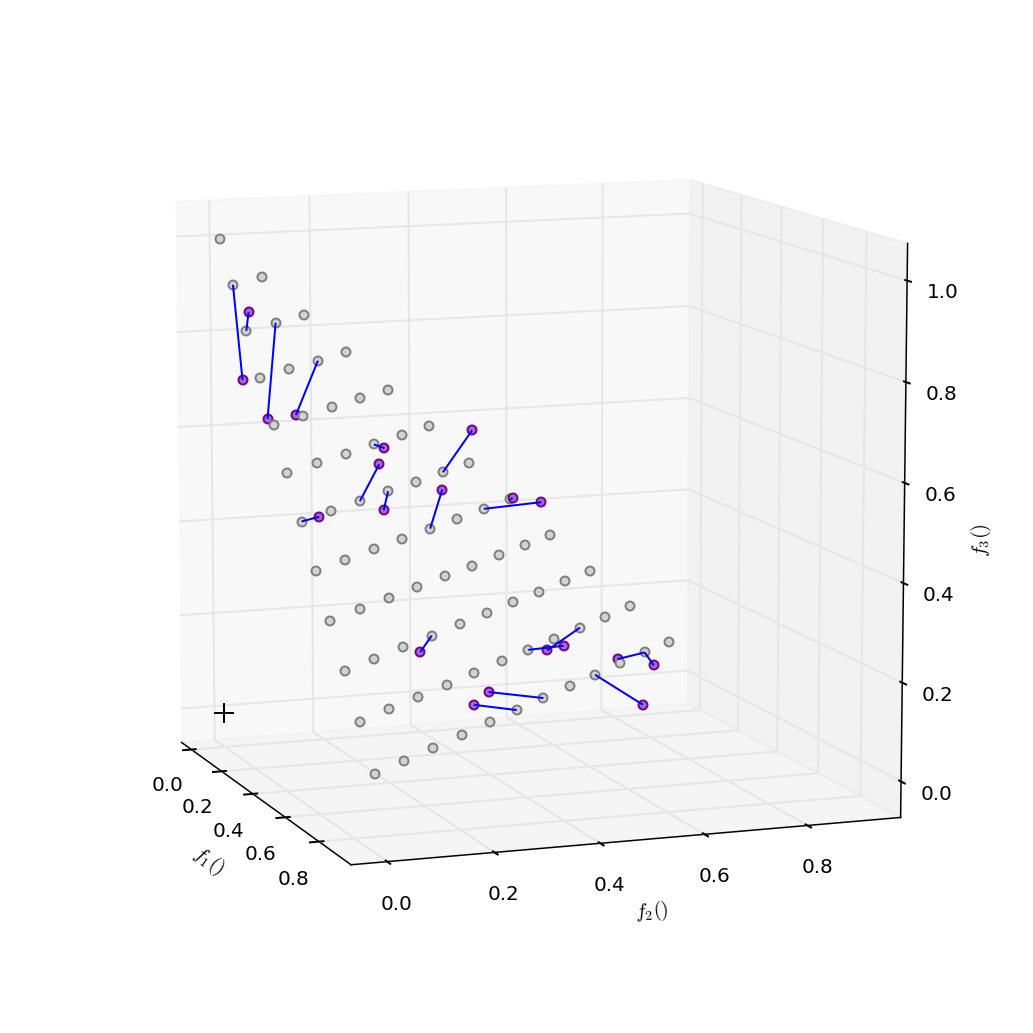

In [35]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
ax.scatter(0,0,0, c='k', marker='+', s=100)

for rp in rps:
    ax.scatter(rp[0], rp[1], rp[2], marker='o', c='lightgray', color='gray')

pairs = []
for ind in pop:
    ax.scatter(ind.fitness.normalized_values[0], 
               ind.fitness.normalized_values[1], 
               ind.fitness.normalized_values[2], color='purple', marker='o', c='mediumpurple')
    pairs += [(ind.fitness.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color('blue')
ax.add_collection3d(lin)

ax.set_xlabel('$f_1()$')
ax.set_ylabel('$f_2()$')
ax.set_zlabel('$f_3()$')
ax.view_init(elev=10., azim=-20)
plt.autoscale(tight=True)

In [36]:
def nsga_iii(toolbox, stats=None, verbose=False):
    population = toolbox.population(n=toolbox.pop_size)
    return algorithms.eaMuPlusLambda(population, toolbox,
                              mu=toolbox.pop_size, 
                              lambda_=toolbox.pop_size, 
                              cxpb=toolbox.cross_prob, 
                              mutpb=toolbox.mut_prob,
                              ngen=toolbox.max_gen,
                              stats=stats, verbose=verbose
                             )

In [21]:
%time res,_ = nsga_iii(toolbox)

CPU times: user 2min 49s, sys: 2.49 s, total: 2min 52s
Wall time: 2min 56s


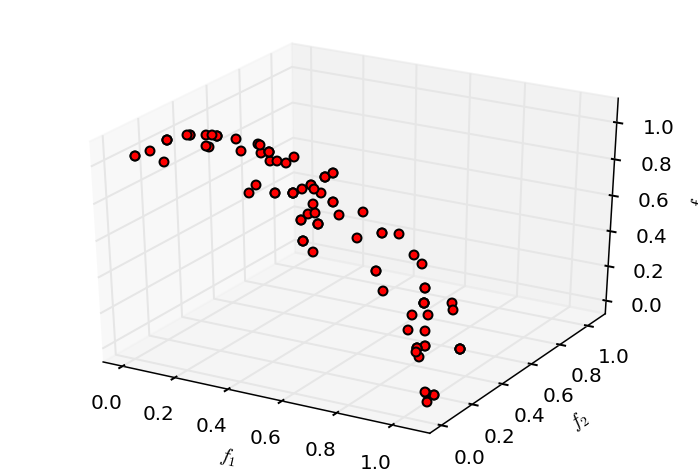

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for ind in res:
    ax.scatter(ind.fitness.values[0],ind.fitness.values[1],ind.fitness.values[2], marker='o', c='r')
ax.set_xlabel('$f_1$')
ax.set_ylabel('$f_2$')
ax.set_zlabel('$f_3$')
plt.autoscale(tight=True)